In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from autoencoder_pipeline import *
from torch.utils.data import DataLoader, TensorDataset


In [2]:
df1 = pd.read_csv('../0.data/results/XKF1_merged.csv')
df2 = pd.read_csv('../0.data/results/XKF2_merged.csv')

select_col1 = ['Roll', 'Pitch', 'GX', 'GY', 'GZ'] # roll, pitch, 각속도
select_col2 = ['AX', 'AY', 'AZ', 'label'] # 가속도

concat_df = pd.concat([df1[select_col1], df2[select_col2]], axis=1)

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# plot_feature_trend(
#     df=concat_df,
#     features=['Roll', 'Pitch', 'GX', 'GY', 'GZ', 'AX', 'AY', 'AZ']
#     )


In [4]:
# 정상 / 이상 분리
nor_df = concat_df.loc[concat_df['label'] == 0]
ab_df = concat_df.loc[concat_df['label'] == 1]

# 정상 데이터 → 학습용 80%, 테스트용 20%
nor_trn, nor_tst = train_test_split(nor_df, test_size=0.2, random_state=42)
nor_tst = nor_tst.drop(columns=['label'])

# 이상 데이터에서 정상 테스트셋과 같은 수만큼 샘플링
ab_tst = ab_df.sample(n=len(nor_tst), random_state=42).drop(columns=['label'])

# 학습을 위해 라벨 제거
X_trn = nor_trn.drop(columns=['label'])

# 확인
print("정상(전체):", len(nor_df))
print("이상(전체):", len(ab_df))
print("정상 훈련용:", len(nor_trn))
print("테스트용 정상:", len(nor_tst))
print("테스트용 이상:", len(ab_tst))


정상(전체): 62379
이상(전체): 63593
정상 훈련용: 49903
테스트용 정상: 12476
테스트용 이상: 12476


### 정상 데이터 학습 & Threshold 구하기

In [5]:
params = {
    'batch_size': 1024,
    'epochs': 700,
    'lr': 1e-5
}

scaler = MinMaxScaler()
scaled_X_trn = scaler.fit_transform(X_trn)

X_trn_tensor = torch.tensor(scaled_X_trn, dtype=torch.float32)

trn_dataset = TensorDataset(X_trn_tensor)
trn_loader = DataLoader(trn_dataset, batch_size=params['batch_size'], shuffle=True)

trained_model, trn_loss_lst = train(trn_loader, **params)

q = 0.95
threshold = compute_threshold(trained_model, X_trn_tensor, q)
print(f"Threshold ({round(q*100)}% quantile): {threshold:.6f}")

device: cuda


100%|██████████| 700/700 [02:19<00:00,  5.01it/s, loss=0.0337]


Threshold (95% quantile): 0.059189


### 정상/이상 테스트 데이터 예측

In [9]:
scaled_nor_tst = scaler.transform(nor_tst)
nor_tst_tensor = torch.tensor(scaled_nor_tst, dtype=torch.float32)


scaled_ab_tst = scaler.transform(ab_tst)
ab_tst_tensor = torch.tensor(scaled_ab_tst, dtype=torch.float32)


nor_recon_error, nor_y_pred = predict(trained_model, nor_tst_tensor, threshold)
nor_y_true = np.zeros_like(nor_y_pred)

ab_recon_error, ab_y_pred = predict(trained_model, ab_tst_tensor, threshold)
ab_y_true = np.ones_like(ab_y_pred)

### Confusion Matrices

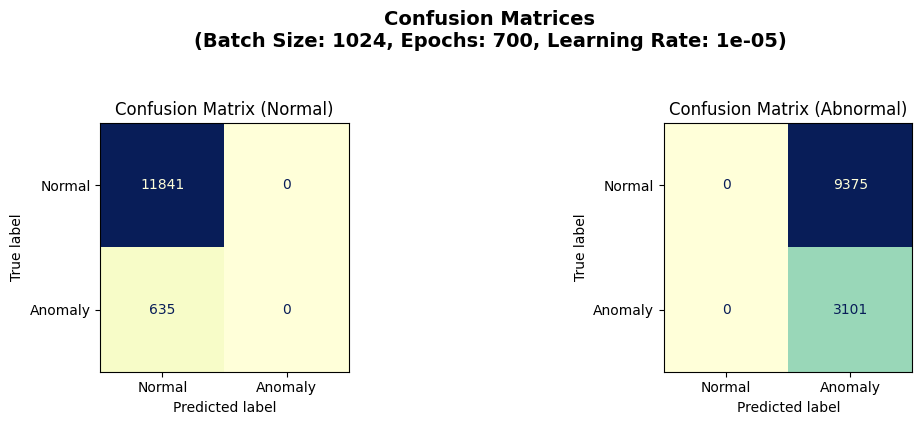

=== 정상 성능 지표 ===
              precision    recall  f1-score   support

      Normal       0.95      1.00      0.97     11841
     Anomaly       0.00      0.00      0.00       635

    accuracy                           0.95     12476
   macro avg       0.47      0.50      0.49     12476
weighted avg       0.90      0.95      0.92     12476

=== 이상 성능 지표 ===
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00      9375
     Anomaly       0.25      1.00      0.40      3101

    accuracy                           0.25     12476
   macro avg       0.12      0.50      0.20     12476
weighted avg       0.06      0.25      0.10     12476



In [10]:
compare_confusion_matrices(nor_y_pred, nor_y_true, ab_y_pred, ab_y_true, **params)

## 

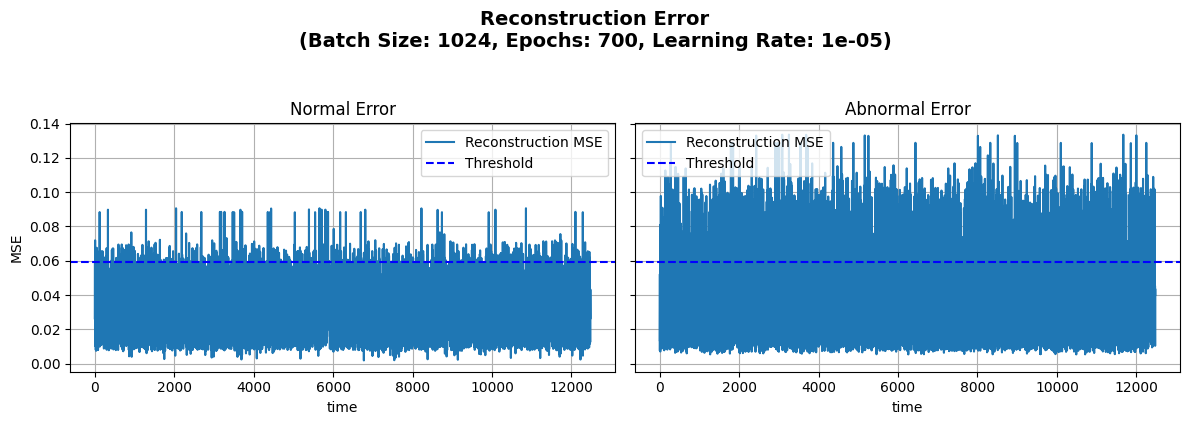

In [11]:
plot_mse_comparison(
    normal_error=nor_recon_error, 
    abnormal_error=ab_recon_error, 
    threshold=threshold,
    **params
)